### Imports

In [603]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [604]:
import pandas as pd 
import os 
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [605]:

from qbt.strategies.strategy_registry import create_strategy, available_strategies



In [606]:
style_path = os.path.join(os.getcwd(), 'styler.mplstyle')
plt.style.use(style_path)

### Main Configs

In [607]:

INTRADAY_FREQ="10min"   # 5 Min, 10 Min, 15 Min
CUTOFF="16:00"      # 3pm, 3:30PM, or 4PM
SELECTION_YEARS=2   # 1, 2, 3 
GRID_SIZE=50      # 20, 50, 100
quantile_bound = 0 # .05, .1, .25
RF="0%"             # or "1m", "3m"
EXEC_TIMING="close_to_close"  # or "open_to_close"


## Sample Run

### Step 1: Construct State Variable

functions to handle rv computation logic

In [608]:
def load_data():
    path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=5Min', 'ticker=XLE', 'bars.parquet')
    df = pd.read_parquet(path)
    df.set_index('timestamp', inplace=True)
    return df

def resample_ohlcv(
    df: pd.DataFrame,
    *,
    rv_freq: str = "10min",
    tz: str | None = "America/New_York",
    session_start: str = "09:30",
    session_end: str = "16:00",
    open_col: str = "open",
    high_col: str = "high",
    low_col: str = "low",
    close_col: str = "close",
    volume_col: str = "volume",
) -> pd.DataFrame:
    x = df.copy()
    if not isinstance(x.index, pd.DatetimeIndex):
        raise ValueError("df must be indexed by a DatetimeIndex.")
    x = x.sort_index()

    tz = tz or "America/New_York"  

    if x.index.tz is None:
        x.index = x.index.tz_localize("UTC").tz_convert(tz)
    else:
        x.index = x.index.tz_convert(tz)

    if session_start and session_end:
        x = x.between_time(session_start, session_end, inclusive="both")

    needed = [open_col, high_col, low_col, close_col]
    missing = [c for c in needed if c not in x.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    agg_map = {open_col: "first", high_col: "max", low_col: "min", close_col: "last"}
    if volume_col in x.columns:
        agg_map[volume_col] = "sum"

    out = x.resample(rv_freq).agg(agg_map)
    out = out.dropna(subset=[open_col, high_col, low_col, close_col], how="all")
    return out




def rv_open_to_cutoff(
    intraday: pd.DataFrame,
    *,
    price_col: str = "close",
    cutoff_time: str = "15:00",
    min_obs: int = 10,
) -> pd.Series:
    
    ret = np.log(intraday[price_col]).diff().dropna()

    # keep only returns with timestamp <= cutoff within each calendar day
    h, m = map(int, cutoff_time.split(":"))
    cutoff_delta = pd.Timedelta(hours=h, minutes=m)
    intraday_offset = ret.index - ret.index.normalize()
    ret = ret[intraday_offset <= cutoff_delta]

    # group by calendar day and sum squared returns
    day = ret.index.normalize()
    rv = ret.pow(2).groupby(day).sum(min_count=1)
    rv = np.sqrt(rv)
    n = ret.groupby(day).count()
    rv[n < min_obs] = np.nan
    
    # rv  = (rv - rv.mean()) / rv.std()
    
    rv.name = "rvol_open_to_cutoff"
    return rv



def rv_cutoff_to_cutoff(
    intraday: pd.DataFrame,
    *,
    price_col: str = "close",
    cutoff_time: str = "16:00",
    min_obs: int = 2,
) -> pd.Series:

    ret = np.log(intraday[price_col]).diff().dropna()
    # bucket by cutoff-defined day:
    # shift forward so that cutoff aligns with midnight, then normalize
    h, m = map(int, cutoff_time.split(":"))
    cutoff_delta = pd.Timedelta(hours=h, minutes=m)
    shift = pd.Timedelta(days=1) - cutoff_delta
    cutoff_day = (ret.index + shift).normalize()

    rv = ret.pow(2).groupby(cutoff_day).sum(min_count=1)
    rv = np.sqrt(rv)
    n = ret.groupby(cutoff_day).count()
    rv[n < min_obs] = np.nan

    # rv  = (rv - rv.mean()) / rv.std()

    rv.name = "rvol_cutoff_to_cutoff"
    return rv


def compute_state_variable(
    df: pd.DataFrame,
    *,
    rv_freq: str = "10min",
    cutoff_time: str = "16:00",
    tz: str | None = "America/New_York",
) -> pd.DataFrame:
    tz = tz or "America/New_York"

    # 1) Intraday resample for RV computations
    intraday = resample_ohlcv(df, rv_freq=rv_freq, tz=tz)

    # 2) RV computations (daily-indexed Series)
    rv_c2c = rv_cutoff_to_cutoff(intraday, cutoff_time=cutoff_time).rename("rvol_c2c")
    rv_o2c = rv_open_to_cutoff(intraday, cutoff_time=cutoff_time).rename("rvol_o2c")

    # 3) Daily OHLCV for returns (RTH)
    daily = resample_ohlcv(df, rv_freq="1D", tz=tz)

    # log returns on daily bars
    # intraday
    daily["ret_oc"] = np.log(daily["close"] / daily["open"])

    # overnight
    daily["ret_co"] = np.log(daily["open"] / daily["close"].shift(1))

    # full close-to-close
    daily["ret_cc"] = daily["ret_co"] + daily["ret_oc"]

    # 4) Merge RV into daily (index alignment by date)
    out = daily.join(rv_c2c, how="left").join(rv_o2c, how="left").sort_index()

    # 5) Add explicit “next-day return” columns for t -> t+1 alignment for trading
    out["ret_cc_next"] = out["ret_cc"].shift(-1)
    out["ret_oc_next"] = out["ret_oc"].shift(-1)
    
    return out

add risk free rate

In [609]:
def merge_w_rf(df):
    path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=1d', 'ticker=TB3MS', 'bars.parquet')
    rf_3m = pd.read_parquet(path).set_index('datetime').tz_convert('America/New_York')
    rf_3m = rf_3m.rename(columns={'close': 'TBILL-3M'})


    path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=1d', 'ticker=DTB4WK', 'bars.parquet')
    rf_1m = pd.read_parquet(path).set_index('datetime').tz_convert('America/New_York')
    rf_1m = rf_1m.rename(columns={'close': 'TBILL-1M'})


    df_day = df.copy()
    rf_1m_day = rf_1m.copy()
    rf_3m_day = rf_3m.copy()

    df_day["date"] = df_day.index.normalize()
    rf_1m_day["date"] = rf_1m_day.index.normalize()
    rf_3m_day["date"] = rf_3m_day.index.normalize()

    df = (
        df_day
        .merge(rf_1m_day[['date', 'TBILL-1M']], on="date", how="left", suffixes=("", "_rf1m"))
        .merge(rf_3m_day[['date', 'TBILL-3M']], on="date", how="left", suffixes=("", "_rf3m"))
        .rename(columns = {'date': 'datetime'})
        .set_index('datetime')
    )

    df['TBILL-1M'] /= 100
    df['TBILL-3M'] /= 100

    return df

In [610]:
def audit_time(df, tz="America/New_York"):
    x = df.copy()
    if x.index.tz is None:
        print("Index is naive. Assuming it's UTC-naive for audit.")
        x.index = x.index.tz_localize("UTC").tz_convert(tz)
    else:
        x.index = x.index.tz_convert(tz)

    # show first few rows around open/close
    s = x.between_time("09:25", "09:40").head(5).index
    e = x.between_time("15:50", "16:10").tail(5).index

    print("Near open:", list(s))
    print("Near close:", list(e))
    print("Unique times near close:", sorted(set(t.time() for t in e)))


In [611]:
df = load_data()
df = compute_state_variable(df)
df = merge_w_rf(df)

In [612]:
df.head()

,open,high,low,close,volume,ret_oc,ret_co,ret_cc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,15.89,16.01,15.55,15.71,1006082,-0.011393,NaN,NaN,0.021171,0.021171,0.045420,0.034027,0.0008,0.0008
2021-01-05 00:00:00-05:00,15.89,16.86,15.89,16.44,1671622,0.034027,0.011393,0.045420,0.030968,0.030968,0.029960,0.010086,0.0009,0.0008
2021-01-06 00:00:00-05:00,16.77,17.09,16.55,16.94,1118084,0.010086,0.019874,0.029960,0.027443,0.027443,0.014068,0.009357,0.0009,0.0008
2021-01-07 00:00:00-05:00,17.02,17.35,16.92,17.18,767390,0.009357,0.004711,0.014068,0.017849,0.017849,-0.000582,-0.011005,0.0008,0.0008
2021-01-08 00:00:00-05:00,17.36,17.39,17.04,17.17,719310,-0.011005,0.010423,-0.000582,0.019700,0.019700,0.015603,0.037388,0.0008,0.0008


In [613]:
print(df.index.min(), df.index.max())

2021-01-04 00:00:00-05:00 2025-12-31 00:00:00-05:00


In [614]:
eps = 1e-10
err = (df["ret_cc"] - (df["ret_co"] + df["ret_oc"])).abs()

print(err)
assert err.dropna().max() < eps, f"CC != CO + OC, max err = {err.max()}"


datetime
2021-01-04 00:00:00-05:00    NaN
2021-01-05 00:00:00-05:00    0.0
2021-01-06 00:00:00-05:00    0.0
2021-01-07 00:00:00-05:00    0.0
2021-01-08 00:00:00-05:00    0.0
                            ... 
2025-12-24 00:00:00-05:00    0.0
2025-12-26 00:00:00-05:00    0.0
2025-12-29 00:00:00-05:00    0.0
2025-12-30 00:00:00-05:00    0.0
2025-12-31 00:00:00-05:00    0.0
Length: 1254, dtype: float64


In [615]:
df["ret_co"].abs().quantile([0.95, 0.99, 0.999])

0.950    0.021705
0.990    0.034153
0.999    0.049254
Name: ret_co, dtype: float64

In [616]:
df[["ret_co", "ret_oc"]].describe(percentiles=[0.01,0.05,0.95,0.99])


,ret_co,ret_oc
count,1253.000000,1254.000000
mean,0.000626,0.000200
std,0.010341,0.013652
min,-0.051262,-0.062548
1%,-0.032259,-0.037708
5%,-0.017875,-0.021410
50%,0.001201,0.000798
95%,0.016642,0.022107
99%,0.025072,0.031255
max,0.041721,0.091530


### Step 2: Split Dataset

In [617]:
def split_data(df: pd.DataFrame, years: int):
    """

    - Use last 5 years of data
    - First `years` years -> selection (Train)
    - Last 2 years -> evaluation (Test)

    Parameters
    ----------
    df : pd.DataFrame
        Must have a DatetimeIndex (daily frequency)
    years : int
        Number of years in selection sample (1, 2, or 3)

    Returns
    -------
    Train : pd.DataFrame
        Selection sample (used to estimate τ*)
    Test : pd.DataFrame
        Evaluation sample (used for trading)
    """
    if years not in {1, 2, 3}:
        raise ValueError("years must be one of {1, 2, 3}")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df must have a DatetimeIndex")

    df = df.sort_index()

    # --- restrict to last 5 years ---
    end_date = df.index.max()
    start_5y = end_date - pd.DateOffset(years=5)

    df_5y = df.loc[start_5y:end_date]

    # --- define cutoffs ---
    test_start = end_date - pd.DateOffset(years=2)
    train_end = df.index.min() + pd.DateOffset(years=years)

    # --- split ---
    Train = df_5y.loc[:train_end]
    Test  = df_5y.loc[test_start:end_date]

    return Train, Test

In [618]:
Train, Test = split_data(df, years=SELECTION_YEARS)


In [619]:
Train

,open,high,low,close,volume,ret_oc,ret_co,ret_cc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,15.89,16.01,15.55,15.71,1006082,-0.011393,NaN,NaN,0.021171,0.021171,0.045420,0.034027,0.0008,0.0008
2021-01-05 00:00:00-05:00,15.89,16.86,15.89,16.44,1671622,0.034027,0.011393,0.045420,0.030968,0.030968,0.029960,0.010086,0.0009,0.0008
2021-01-06 00:00:00-05:00,16.77,17.09,16.55,16.94,1118084,0.010086,0.019874,0.029960,0.027443,0.027443,0.014068,0.009357,0.0009,0.0008
2021-01-07 00:00:00-05:00,17.02,17.35,16.92,17.18,767390,0.009357,0.004711,0.014068,0.017849,0.017849,-0.000582,-0.011005,0.0008,0.0008
2021-01-08 00:00:00-05:00,17.36,17.39,17.04,17.17,719310,-0.011005,0.010423,-0.000582,0.019700,0.019700,0.015603,0.037388,0.0008,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 00:00:00-05:00,39.67,39.67,38.76,38.89,587462,-0.019858,-0.003020,-0.022878,0.015591,0.015591,0.009724,0.014105,0.0388,0.0425
2022-12-29 00:00:00-05:00,38.72,39.46,38.70,39.27,584710,0.014105,-0.004381,0.009724,0.010077,0.010077,0.006852,0.011446,0.0395,0.0425
2022-12-30 00:00:00-05:00,39.09,39.60,39.09,39.54,509874,0.011446,-0.004594,0.006852,0.011629,0.011629,-0.037099,-0.029737,0.0395,0.0425


In [620]:
Test

,open,high,low,close,volume,ret_oc,ret_co,ret_cc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,39.530,40.060,39.520,39.730,676502,0.005047,0.006599,0.011646,0.012427,0.012427,0.014989,0.016248,0.0527,0.0522
2024-01-03 00:00:00-05:00,39.680,40.480,39.560,40.330,833186,0.016248,-0.001259,0.014989,0.009108,0.009108,-0.016752,-0.023917,0.0529,0.0522
2024-01-04 00:00:00-05:00,40.620,40.780,39.610,39.660,699678,-0.023917,0.007165,-0.016752,0.010006,0.010006,0.000504,-0.006781,0.0528,0.0522
2024-01-05 00:00:00-05:00,39.950,40.010,39.500,39.680,490304,-0.006781,0.007286,0.000504,0.010121,0.010121,-0.011406,0.006650,0.0528,0.0522
2024-01-08 00:00:00-05:00,38.970,39.260,38.460,39.230,885242,0.006650,-0.018055,-0.011406,0.026814,0.026814,-0.016967,-0.017222,0.0528,0.0522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 00:00:00-05:00,44.450,44.550,44.315,44.365,528280,-0.001914,-0.000899,-0.002814,0.005843,0.005843,-0.003613,-0.001921,NaN,0.0359
2025-12-26 00:00:00-05:00,44.290,44.430,43.995,44.205,1074621,-0.001921,-0.001692,-0.003613,0.004992,0.004992,0.009344,0.003030,0.0356,0.0359
2025-12-29 00:00:00-05:00,44.485,44.740,44.295,44.620,1678225,0.003030,0.006314,0.009344,0.007349,0.007349,0.008036,0.003452,0.0350,0.0359


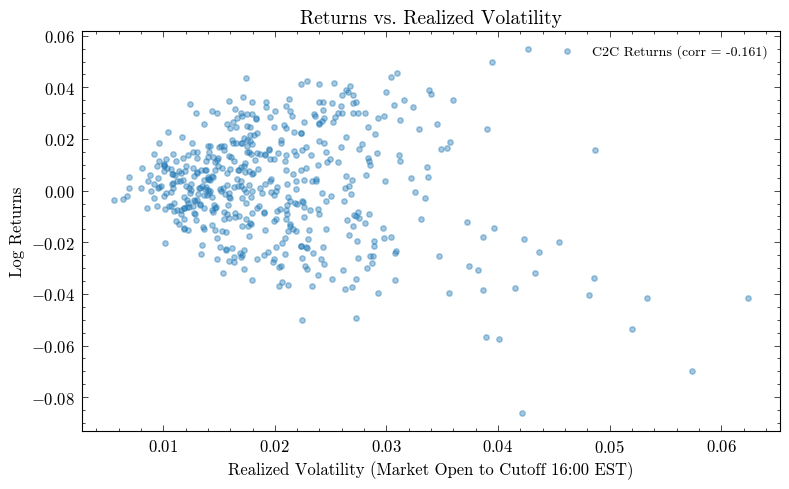

In [621]:
# compute correlations
corr_cc = Train['rvol_o2c'].corr(Train['ret_cc'])
corr_oc = Train['rvol_o2c'].corr(Train['ret_oc'])

plt.figure(figsize=(8, 5))

plt.scatter(
    Train['rvol_o2c'],
    Train['ret_cc'],
    alpha=0.4,
    s=15,
    label=f'C2C Returns (corr = {corr_cc:.3f})'
)

# plt.scatter(
#     Train['rvol_o2c'],
#     Train['ret_oc'],
#     alpha=0.4,
#     s=15,
#     label=f'O2C Returns (corr = {corr_oc:.3f})'
# )

# plt.axhline(0, linewidth=1, alpha=0.6)

plt.title('Returns vs. Realized Volatility', fontsize=14)
plt.xlabel(f'Realized Volatility (Market Open to Cutoff {CUTOFF} EST)', fontsize=12)

plt.ylabel('Log Returns', fontsize=12)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()


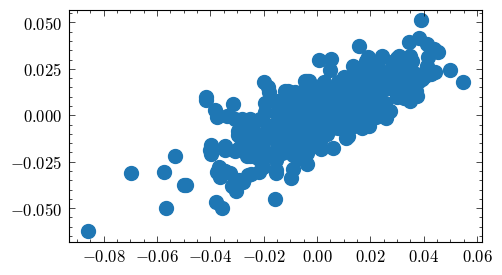

In [622]:
plt.scatter(Train['ret_cc'], Train['ret_oc'])

In [623]:
Train[['rvol_o2c', 'ret_cc', 'ret_oc', 'ret_co']].corr()

,rvol_o2c,ret_cc,ret_oc,ret_co
rvol_o2c,1.000000,-0.160810,-0.043114,-0.200574
ret_cc,-0.160810,1.000000,0.773741,0.619898
ret_oc,-0.043114,0.773741,1.000000,-0.017457
ret_co,-0.200574,0.619898,-0.017457,1.000000


In [624]:
Train[["ret_co", "ret_oc"]].std()

ret_co    0.013076
ret_oc    0.016190
dtype: float64

In [625]:
df[["ret_co", "ret_oc"]].agg(["mean", "std"])


,ret_co,ret_oc
mean,0.000626,0.000200
std,0.010341,0.013652


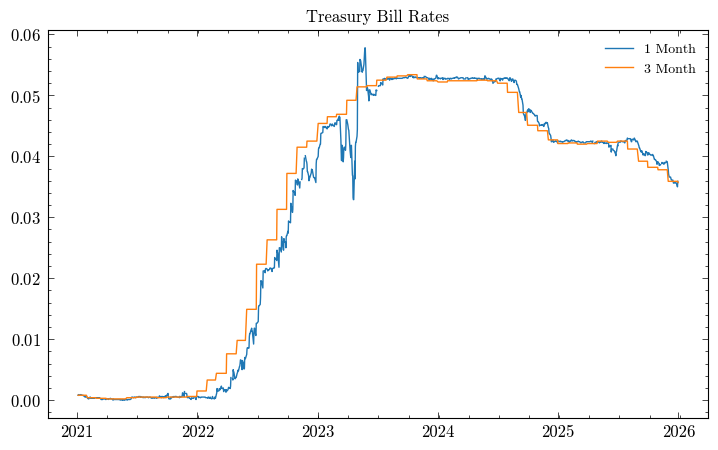

In [626]:

plt.figure(figsize=(8, 5))
plt.title('Treasury Bill Rates')
plt.plot(df['TBILL-1M'], label = "1 Month")
plt.plot(df['TBILL-3M'], label = "3 Month")

plt.legend()


### Step 3: Candidate Thresholds

In [627]:

def candidate_thresholds(state_var, n_grid, min_quintile=0):
    s = np.asarray(state_var)
    s = s[~np.isnan(s)]  # defensive: drop NaNs

    if s.size == 0:
        raise ValueError("state_var contains no valid observations")

    if min_quintile > 0:
        qs = np.linspace(min_quintile/2, 1.0 - min_quintile/2, n_grid, endpoint=True)
    else:
        qs = np.linspace(0.0, 1.0, n_grid, endpoint=True)

    candidates = np.unique(np.quantile(s, qs))

    return candidates

### Step 4 : Regime Classification

In [628]:
def regime_classification(state_var, tau, df):
    mask = state_var <= tau
    low = df[mask]
    high = df[~mask]             
    
    return low, high

### Step 5 : Sharpe Ratios of Regime

In [629]:


def _sharpe(
    ret: pd.Series,
    *,
    rf: pd.Series | None = None,
    ann_factor: int = 252,
) -> float:
    r = ret.dropna()

    if r.empty:
        return np.nan

    if rf is None:
        excess = r
    else:
     
        rf = rf.reindex(r.index)
        rf = rf.ffill()
        excess = r - rf

   

    sd = excess.std(ddof=0)
    if sd <= 0 or np.isnan(sd):
        return np.nan

    return float(excess.mean() / sd * np.sqrt(ann_factor))


def sharpe_ratio_by_regime(
    low: pd.DataFrame,
    high: pd.DataFrame,
    *,
    ret_col: str = "ret_cc",
    risk_free_rate: str = "0%",   # "0%", "TBILL-1M", "TBILL-3M"
    ann_factor: int = 252,
):
    """
    Computes Sharpe ratios for low- and high-regime subsets using the same Sharpe logic.
    """

    # --- extract returns ---
    r_low = low[ret_col].dropna()
    r_high = high[ret_col].dropna()

    # --- build rf series (aligned later inside _sharpe) ---
    if risk_free_rate == "0%" or risk_free_rate is None:
        rf_series_low = None
        rf_series_high = None

    elif risk_free_rate in ("TBILL-1M", "1m", "1M"):
        rf_series_low = (low["TBILL-1M"] ) / ann_factor
        rf_series_high = (high["TBILL-1M"] ) / ann_factor

    elif risk_free_rate in ("TBILL-3M", "3m", "3M"):
        rf_series_low = (low["TBILL-3M"] ) / ann_factor
        rf_series_high = (high["TBILL-3M"] ) / ann_factor

    else:
        raise ValueError(f"Unknown risk_free_rate: {risk_free_rate}")

    # --- Sharpe ratios using the SAME function ---
    sr_low = _sharpe(r_low, rf=rf_series_low, ann_factor=ann_factor)
    sr_high = _sharpe(r_high, rf=rf_series_high, ann_factor=ann_factor)

    return sr_low, sr_high

### Step 6: chose the threshold

In [630]:
def choose_threshold(df, n_grid, min_quintile=.10, risk_free_rate=0):
    results = []

    tau_star = None
    best_obj = -np.inf
    state_var_arr = df['rvol_o2c']

    candidates = candidate_thresholds(state_var_arr, n_grid, min_quintile)
    for tau in candidates:
        low, high = regime_classification(state_var_arr, tau, df)

        n_low = len(low)
        n_high = len(high)
        # if n_low < 5 or n_high < 5:
        #     continue
        
        sr_low, sr_high = sharpe_ratio_by_regime(low, high, risk_free_rate=risk_free_rate)


        if np.isnan(sr_low) or np.isnan(sr_high):
            continue

        obj = sr_low - sr_high


        results.append({'tau': tau, 'sharpe_diff': obj, 'sharpe_low_state': sr_low, 'sharpe_high_state': sr_high, 'n_low': n_low, 'n_high': n_high})


        if obj > best_obj:
            best_obj = obj
            tau_star = float(tau)


    return tau_star, pd.DataFrame(results)



In [631]:
tau_star, res = choose_threshold(Train, GRID_SIZE, min_quintile=quantile_bound, risk_free_rate=RF)

In [632]:
print(res['tau'].max())

0.042596130716832346


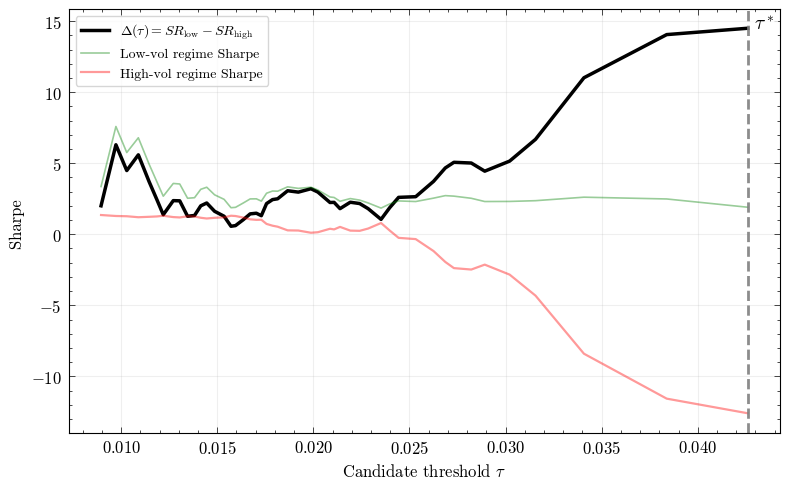

In [633]:
plt.figure(figsize=(8, 5))

# Main Sharpe difference
plt.plot(
    res["tau"],
    res["sharpe_diff"],
    label=r"$\Delta(\tau) = SR_{\text{low}} - SR_{\text{high}}$",
    linewidth=2.5,
    color="black"
)

# Regime Sharpes (low alpha, clear colors)
plt.plot(
    res["tau"],
    res["sharpe_low_state"],
    label="Low-vol regime Sharpe",
    color="green",
    alpha=0.4,
    linewidth=1.2
)

plt.plot(
    res["tau"],
    res["sharpe_high_state"],
    label="High-vol regime Sharpe",
    color="red",
    alpha=0.4,
    linewidth=1.6
)

# Tau star
plt.axvline(
    tau_star,
    linestyle="--",
    linewidth=2,
    color="grey",
    alpha=0.9
)

# Bold tau star annotation
x_offset = 0.01 * (res["tau"].max() - res["tau"].min())
ymax = plt.ylim()[1]

plt.text(
    tau_star + x_offset,
    ymax * 0.97,
    r"$\boldsymbol{\tau^*}$",
    ha="left",
    va="top",
    fontsize=14,
    fontweight="bold",
    color="black",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="white",
        edgecolor="none",
        alpha=0.8
    )
)


# Labels
plt.xlabel(r"Candidate threshold $\tau$")
plt.ylabel(r"Sharpe ")

# Legend
plt.legend(frameon=True)

# Clean look
plt.grid(alpha=0.2)
plt.tight_layout()


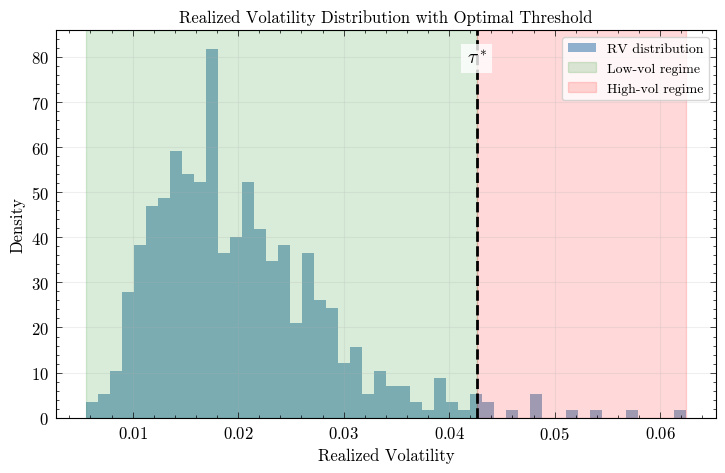

In [634]:
plt.figure(figsize=(8, 5))

plt.hist(
    Train["rvol_o2c"],
    bins=50,
    density=True,
    alpha=0.6,
    color="steelblue",
    label="RV distribution"
)

# Shade regimes
plt.axvspan(
    Train["rvol_o2c"].min(),
    tau_star,
    color="green",
    alpha=0.15,
    label="Low-vol regime"
)

plt.axvspan(
    tau_star,
    Train["rvol_o2c"].max(),
    color="red",
    alpha=0.15,
    label="High-vol regime"
)

# τ*
plt.axvline(tau_star, linestyle="--", linewidth=2, color="black")

ymax = plt.ylim()[1]
plt.text(
    tau_star,
    ymax * 0.95,
    r"$\boldsymbol{\tau^*}$",
    ha="center",
    va="top",
    fontsize=14,
    fontweight="bold",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

plt.xlabel("Realized Volatility")
plt.ylabel("Density")
plt.title("Realized Volatility Distribution with Optimal Threshold")
plt.legend(frameon=True)
plt.grid(alpha=0.2)
plt.show()


### Step 7: Trading rule in evaluation sample

In [635]:
Test

,open,high,low,close,volume,ret_oc,ret_co,ret_cc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,39.530,40.060,39.520,39.730,676502,0.005047,0.006599,0.011646,0.012427,0.012427,0.014989,0.016248,0.0527,0.0522
2024-01-03 00:00:00-05:00,39.680,40.480,39.560,40.330,833186,0.016248,-0.001259,0.014989,0.009108,0.009108,-0.016752,-0.023917,0.0529,0.0522
2024-01-04 00:00:00-05:00,40.620,40.780,39.610,39.660,699678,-0.023917,0.007165,-0.016752,0.010006,0.010006,0.000504,-0.006781,0.0528,0.0522
2024-01-05 00:00:00-05:00,39.950,40.010,39.500,39.680,490304,-0.006781,0.007286,0.000504,0.010121,0.010121,-0.011406,0.006650,0.0528,0.0522
2024-01-08 00:00:00-05:00,38.970,39.260,38.460,39.230,885242,0.006650,-0.018055,-0.011406,0.026814,0.026814,-0.016967,-0.017222,0.0528,0.0522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 00:00:00-05:00,44.450,44.550,44.315,44.365,528280,-0.001914,-0.000899,-0.002814,0.005843,0.005843,-0.003613,-0.001921,NaN,0.0359
2025-12-26 00:00:00-05:00,44.290,44.430,43.995,44.205,1074621,-0.001921,-0.001692,-0.003613,0.004992,0.004992,0.009344,0.003030,0.0356,0.0359
2025-12-29 00:00:00-05:00,44.485,44.740,44.295,44.620,1678225,0.003030,0.006314,0.009344,0.007349,0.007349,0.008036,0.003452,0.0350,0.0359


In [636]:
def simulate_trading(
    test: pd.DataFrame,
    *,
    tau: float,
    state_col: str = "rvol_o2c",
    ret_cc_next_col: str = "ret_cc_next",
    ret_o2c_next_col: str = "ret_oc_next",
    # --- transaction cost controls ---
    tcost_bps: float = 0.0,      # e.g. 5 = 5 bps per trade
    apply_on: str = "entry",      # "both" | "entry" | "exit"
) -> pd.DataFrame:
    """
    Transaction cost model:
      - signal_t in {0,1} is target position for day t (decided at t).
      - You earn next-period returns when you're in the position.
      - You pay costs when you change position (turnover).
        * both: pay on any change (0->1 or 1->0)
        * entry: pay only on 0->1
        * exit:  pay only on 1->0
    Costs are subtracted from strategy return on the day the trade happens.
    """

    x = test.copy().sort_index()

    # --- signal / position (0/1) ---
    x["signal_t"] = (x[state_col] < tau).astype(int)

    # --- returns before costs ---
    x["strat_ret_c2c_gross"] = x["signal_t"] * x[ret_cc_next_col]
    x["strat_ret_o2c_gross"] = x["signal_t"] * x[ret_o2c_next_col]

    # keep rows where both returns exist
    x = x.dropna(subset=[ret_cc_next_col, ret_o2c_next_col]).copy()

    # --- turnover / trade indicator ---
    prev = x["signal_t"].shift(1).fillna(0).astype(int)
    curr = x["signal_t"].astype(int)

    # any position change (0->1 or 1->0) is a trade
    turn = (curr - prev).abs()

    if apply_on == "entry":
        trade = ((prev == 0) & (curr == 1)).astype(int)
    elif apply_on == "exit":
        trade = ((prev == 1) & (curr == 0)).astype(int)
    elif apply_on == "both":
        trade = turn.astype(int)
    else:
        raise ValueError("apply_on must be one of: 'both', 'entry', 'exit'")

    x["turnover"] = turn
    x["trade"] = trade

    # --- transaction costs as decimal return ---
    tcost = (tcost_bps / 10_000.0) * x["trade"]
    x["tcost"] = tcost

    # --- net returns ---
    x["strat_ret_c2c"] = x["strat_ret_c2c_gross"] - x["tcost"]
    x["strat_ret_o2c"] = x["strat_ret_o2c_gross"] - x["tcost"]

    cols = [
        state_col, "signal_t", "trade", "turnover", "tcost",
        ret_cc_next_col, "strat_ret_c2c_gross", "strat_ret_c2c",
        ret_o2c_next_col, "strat_ret_o2c_gross", "strat_ret_o2c",
        "TBILL-1M", "TBILL-3M"
    ]
    # keep only columns that exist
    cols = [c for c in cols if c in x.columns]
    return x[cols]


In [637]:
strat_returns = simulate_trading(Test, tau=tau_star)

In [638]:

def evaluate_strategy(
    df: pd.DataFrame,
    *,
    ret_col: str = "strat_ret",
    signal_col: str = "signal_t",
    ann_factor: int = 252,
    rf: str = "0%",   # "0%", "TBILL-1M"/"1m", "TBILL-3M"/"3m"
    convention: str='c2c'
) -> dict:
    """
    Computes:
      - cumulative return (from log returns)
      - annualized Sharpe (excess if rf != 0)
      - conditional Sharpe by regime (excess if rf != 0)
      - number of buy days
      - turnover
      - max drawdown
    """

    x = df.copy().sort_index()

    r = x[ret_col].dropna()
    if r.empty:
        return {
            "cumulative_return": np.nan,
            "sharpe": np.nan,
            "sharpe_buy_regime": np.nan,
            "sharpe_no_buy_regime": np.nan,
            "num_buy_days": 0,
            "num_no_buy_days": 0,
            "turnover": np.nan,
            "max_drawdown": np.nan,
        }

    signal = x[signal_col].reindex(r.index)

    # ---------- build per-period rf series (aligned later) ----------
    rf_key = (rf or "0%")
    rf_key_l = rf_key.lower()

    if rf_key == "0%" or rf_key_l in ("0", "none", "null"):
        rf_series = None
    elif rf_key in ("TBILL-1M",) or rf_key_l in ("1m", "tbill-1m", "tbill_1m"):
        if "TBILL-1M" not in x.columns:
            raise ValueError("Missing column 'TBILL-1M' in df for rf='TBILL-1M'.")
        rf_series = (x["TBILL-1M"]) / ann_factor
    elif rf_key in ("TBILL-3M",) or rf_key_l in ("3m", "tbill-3m", "tbill_3m"):
        if "TBILL-3M" not in x.columns:
            raise ValueError("Missing column 'TBILL-3M' in df for rf='TBILL-3M'.")
        rf_series = (x["TBILL-3M"]) / ann_factor
    else:
        raise ValueError(f"Unknown rf: {rf}")

    # ---------- Equity curve (log returns) ----------
    equity = np.exp(r.fillna(0).cumsum())

    # ---------- Cumulative return ----------
    cumulative_return = float(equity.iloc[-1] - 1.0)

    # ---------- Sharpe (overall + by regime) ----------
    sharpe = _sharpe(r, rf=rf_series, ann_factor=ann_factor)

    exec_ret = (
        df["ret_cc_next"] if convention == "c2c"
        else df["ret_oc_next"]
    )

    r_buy = exec_ret[signal == 1]
    r_no_buy = exec_ret[signal == 0]


    sharpe_buy = _sharpe(r_buy, rf=rf_series, ann_factor=ann_factor)
    sharpe_no_buy = _sharpe(r_no_buy, rf=rf_series, ann_factor=ann_factor)

    # ---------- Number of buy days ----------
    num_buy_days = int((signal == 1).sum())
    num_no_buy_days = int((signal == 0).sum())

    # ---------- Turnover ----------
    turnover = float(signal.dropna().diff().abs().sum())

    # ---------- Max Drawdown ----------
    running_max = equity.cummax()
    drawdown = equity / running_max - 1.0
    max_drawdown = float(drawdown.min())

    return {
        "cumulative_return": cumulative_return,
        "sharpe": float(sharpe),
        "sharpe_buy_regime": float(sharpe_buy),
        "sharpe_no_buy_regime": float(sharpe_no_buy),
        "num_buy_days": num_buy_days,
        "num_no_buy_days": num_no_buy_days,
        "turnover": turnover,
        "max_drawdown": max_drawdown,
    }


In [639]:
stats_c2c = evaluate_strategy(
    strat_returns.rename(columns={"strat_ret_c2c": "strat_ret"}),
    ret_col="strat_ret",
    signal_col="signal_t",
)

stats_o2c = evaluate_strategy(
    strat_returns.rename(columns={"strat_ret_o2c": "strat_ret"}),
    ret_col="strat_ret",
    signal_col="signal_t",
    convention='o2c'
)

stats_bh = evaluate_strategy(
    Test.assign(signal_t=1).rename(columns={"ret_cc": "strat_ret"}),
    ret_col="strat_ret",
    signal_col="signal_t",
    convention='c2c'
)



Evaluation-sample stats:


,cumulative_return,sharpe,sharpe_buy_regime,sharpe_no_buy_regime,num_buy_days,num_no_buy_days,turnover,max_drawdown
Buy & Hold,0.138783,0.304709,0.277878,NaN,501.0,0.0,0.0,-0.201200
Close-to-Close,0.305886,0.684846,0.689001,-9.165179,494.0,6.0,6.0,-0.142918
Open-to-Close,-0.009026,-0.026544,-0.026705,-7.613232,494.0,6.0,6.0,-0.236457


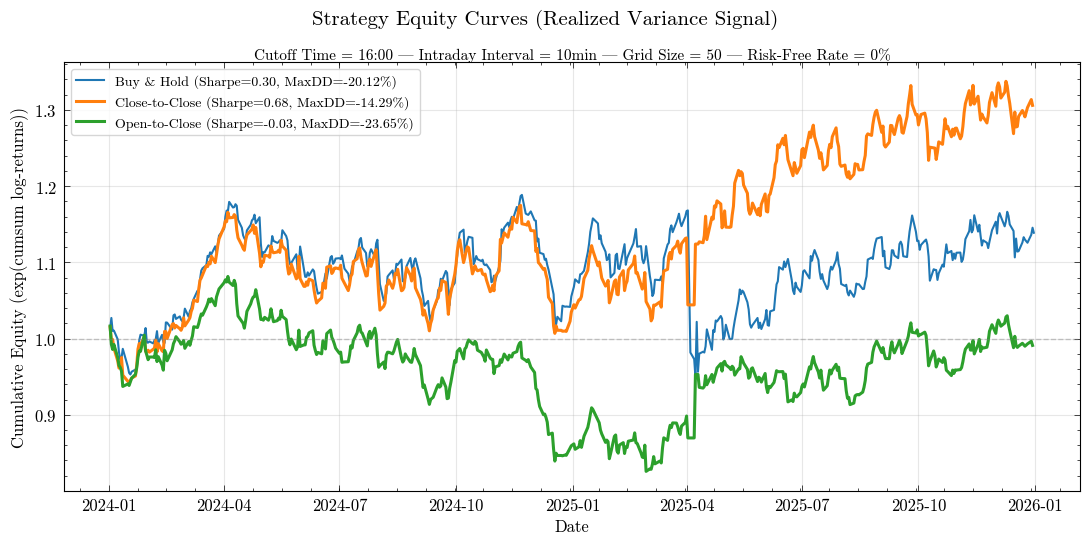

In [640]:
summary = (
    pd.DataFrame(
        {
            "Buy & Hold": stats_bh,
            "Close-to-Close": stats_c2c,
            "Open-to-Close": stats_o2c,
        }
    )
    .T
)

# nice formatting (optional)
summary_fmt = summary.copy()
for c in ["cumulative_return", "sharpe", "sharpe_buy_regime", "sharpe_no_buy_regime", "max_drawdown"]:
    if c in summary_fmt.columns:
        summary_fmt[c] = summary_fmt[c].map(lambda v: np.nan if pd.isna(v) else float(v))

print("\nEvaluation-sample stats:")
display(summary_fmt)  # in notebooks; if not, use print(summary_fmt)

# --- equity curves from log returns ---
eq_c2c = np.exp(strat_returns["strat_ret_c2c"].fillna(0).cumsum())
eq_o2c = np.exp(strat_returns["strat_ret_o2c"].fillna(0).cumsum())
eq_bh  = np.exp(Test["ret_cc"].fillna(0).cumsum())

# --- plot ---
plt.figure(figsize=(11, 6))

plt.plot(eq_bh,  lw=1.5, label=f"Buy & Hold (Sharpe={stats_bh['sharpe']:.2f}, MaxDD={stats_bh['max_drawdown']:.2%})")
plt.plot(eq_c2c, lw=2.2, label=f"Close-to-Close (Sharpe={stats_c2c['sharpe']:.2f}, MaxDD={stats_c2c['max_drawdown']:.2%})")
plt.plot(eq_o2c, lw=2.2, label=f"Open-to-Close (Sharpe={stats_o2c['sharpe']:.2f}, MaxDD={stats_o2c['max_drawdown']:.2%})")

plt.axhline(1.0, color="gray", linestyle="--", alpha=0.4)

plt.suptitle(
    "Strategy Equity Curves (Realized Variance Signal)",
    fontsize=15,
    fontweight="bold",
    y=0.9   # move suptitle slightly down if needed
)

subtitle = (
    f"Cutoff Time = {CUTOFF} | "
    f"Intraday Interval = {INTRADAY_FREQ} | "
    f"Grid Size = {GRID_SIZE} | "
    f"Risk-Free Rate = {RF}"
)

plt.title(subtitle, fontsize=11, pad=1)  # <-- key line

plt.xlabel("Date")
plt.ylabel("Cumulative Equity (exp(cumsum log-returns))")
plt.grid(alpha=0.3)
plt.legend(frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## Parameter Sensitivity

In [641]:
import uuid
from datetime import datetime, timezone


def _new_run_id() -> str:
    ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
    return f"{ts}_{uuid.uuid4().hex[:8]}"

def _flatten(prefix: str, d: dict) -> dict:
    return {f"{prefix}{k}": v for k, v in d.items()}

In [642]:
def run_one(
    *,
    intraday_freq: str,
    cutoff: str,
    selection_years: int | float,
    grid_size: int,
    rf: str,                        # "0%", "TBILL-1M", "TBILL-3M"
    tau_quantile_bounds: .0,  # replaces min_quintile
    transaction_cost: 0
) -> dict:
    """
    Returns a dict of artifacts:
      - meta: params + run_id + tau_star
      - stats: dict of summary metrics for c2c and o2c
      - equity: long DF with equity curves (c2c/o2c/bh)
      - thresholds: optional DF with grid search results (res)
    """

    run_id = _new_run_id()

    df = load_data()
    df = compute_state_variable(df, rv_freq=intraday_freq, cutoff_time=cutoff)
    df = merge_w_rf(df)  # should include the rf columns needed downstream

    train, test = split_data(df, years=selection_years)


    tau_star, res = choose_threshold(
        train,
        grid_size,
        min_quintile=tau_quantile_bounds,   # keep your signature; see note below
        risk_free_rate=rf
    )

    strat_returns = simulate_trading(test, tau=tau_star, tcost_bps=transaction_cost)

    # --- stats ---
    stats_c2c = evaluate_strategy(
        strat_returns.rename(columns={"strat_ret_c2c": "strat_ret"}),
        ret_col="strat_ret",
        signal_col="signal_t",
        rf=rf
    )
    stats_o2c = evaluate_strategy(
        strat_returns.rename(columns={"strat_ret_o2c": "strat_ret"}),
        ret_col="strat_ret",
        signal_col="signal_t",
        rf=rf
    )

    # buy&hold baseline stats (assumes test has ret_cc log returns)
    stats_bh = evaluate_strategy(
        test.assign(signal_t=1).rename(columns={"ret_oc": "strat_ret"}),
        ret_col="strat_ret",
        signal_col="signal_t",
        rf=rf
    )


    # --- equity curves (log returns) in long format for dashboards ---
    eq = pd.DataFrame(index=test.index.copy())
    eq["bh"] = np.exp(test["ret_cc"].fillna(0).cumsum())
    eq["c2c"] = np.exp(strat_returns["strat_ret_c2c"].fillna(0).cumsum())
    eq["o2c"] = np.exp(strat_returns["strat_ret_o2c"].fillna(0).cumsum())

    equity_long = (
        eq.reset_index()
          .rename(columns={eq.index.name or "index": "timestamp"})
          .melt(id_vars="timestamp", var_name="strategy", value_name="equity")
    )
    equity_long["run_id"] = run_id

    # --- pack meta + summary row ---
    meta = {
        "run_id": run_id,
        "intraday_freq": intraday_freq,
        "cutoff": cutoff,
        "selection_years": selection_years,
        "grid_size": grid_size,
        "rf": rf,
        "tau_star": float(tau_star),
        "tau_quantile_bounds": float(tau_quantile_bounds),
        "transaction_cost": float(transaction_cost)
    }

    # one-row summary for dashboard filters
    summary_row = {
        **meta,
        **_flatten("bh_", stats_bh),
        **_flatten("c2c_", stats_c2c),
        **_flatten("o2c_", stats_o2c),
    }

    # threshold diagnostics table (if res is a DF-like object)
    thresholds = None
    if res is not None:
        thresholds = res.copy()
        thresholds["run_id"] = run_id

    return {
        "meta": meta,
        "summary": summary_row,          # dict
        "equity_long": equity_long,      # DF
        "thresholds": thresholds,        # DF or None
        "strat_returns": strat_returns,  # DF (optional, for debugging)
    }


In [643]:

def sweep_one_param_and_plot(
    *,
    values: list[str],
    param_name: str,
    base_kwargs: dict,
    plot_strategy: str = "c2c",   # "c2c", "o2c", or "bh"
    figsize=(11, 6),
):
    summaries = []
    equities = []
    run_outputs = []

    for v in values:
        kwargs = dict(base_kwargs)
        kwargs[param_name] = v

        out = run_one(**kwargs)
        run_outputs.append(out)

        summaries.append(out["summary"])
        equities.append(out["equity_long"])

    summary_df = pd.DataFrame(summaries)
    equity_long = pd.concat(equities, ignore_index=True)

    # ---- overlay equity curves for chosen strategy ----
    plt.figure(figsize=figsize)

    for out in run_outputs:
        meta = out["meta"]
        rid = meta["run_id"]
        label = f"{param_name}={meta[param_name]} (τ*={meta['tau_star']:.3g}, Sharpe={out['summary']['c2c_sharpe']:.2f})"

        # pick one curve (c2c/o2c/bh) from long DF
        e = out["equity_long"]
        e = e[e["strategy"] == plot_strategy].sort_values("timestamp")

        # robust line label based on chosen strategy
        if plot_strategy == "c2c":
            sh = out["summary"]["c2c_sharpe"]
            label = rf"{param_name}={meta[param_name]} ($\tau^*$={meta['tau_star']:.3g}, Sharpe={sh:.2f})"
        elif plot_strategy == "o2c":
            sh = out["summary"]["o2c_sharpe"]
            label = rf"{param_name}={meta[param_name]} ($\tau^*$={meta['tau_star']:.3g}, Sharpe={sh:.2f})"
        else:
            sh = out["summary"]["bh_sharpe"]
            label = rf"{param_name}={meta[param_name]} (Sharpe={sh:.2f})"

        plt.plot(e["timestamp"], e["equity"], lw=2, label=label)

    plt.axhline(1.0, color="gray", linestyle="--", alpha=0.4)
    plt.suptitle("Equity Curves (Single-Parameter Sweep)", fontsize=15, fontweight="bold")
    # plt.title(f"Overlay: strategy={plot_strategy} | fixed cutoff={base_kwargs.get('cutoff')} | rf={base_kwargs.get('rf')}", fontsize=11, color="dimgray")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Equity")
    plt.grid(alpha=0.3)
    plt.legend(frameon=True, fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    return {
        "summary": summary_df,
        "equity_long": equity_long,
        "runs": run_outputs,
    }


In [644]:
base_kwargs = dict(
    intraday_freq = INTRADAY_FREQ,
    cutoff=CUTOFF,
    selection_years=SELECTION_YEARS,
    grid_size=GRID_SIZE,
    rf=RF,
    tau_quantile_bounds=0.0,
    transaction_cost=0.0
)

Intraday freq

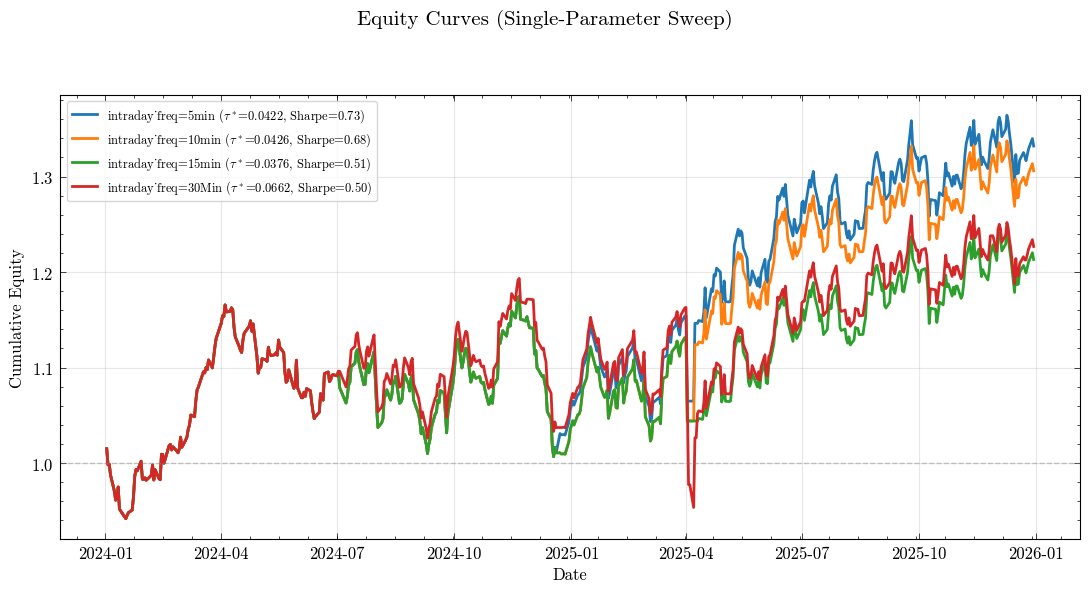

,intraday_freq,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
0,5min,0.733703,0.737408,-12.837692,4.0,495,5
1,10min,0.684846,0.689001,-9.165179,6.0,494,6
2,15min,0.514135,0.517776,-3.231505,4.0,493,7
3,30Min,0.495075,0.499596,-6.729780,16.0,491,9


In [656]:
rv_frequencies = ["5min", "10min", "15min", "30Min"]


out_sweep = sweep_one_param_and_plot(
    values=rv_frequencies,
    param_name="intraday_freq",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['intraday_freq', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

In [657]:
summary_df.columns

Index(['run_id', 'intraday_freq', 'cutoff', 'selection_years', 'grid_size',
       'rf', 'tau_star', 'tau_quantile_bounds', 'transaction_cost',
       'bh_cumulative_return', 'bh_sharpe', 'bh_sharpe_buy_regime',
       'bh_sharpe_no_buy_regime', 'bh_num_buy_days', 'bh_num_no_buy_days',
       'bh_turnover', 'bh_max_drawdown', 'c2c_cumulative_return', 'c2c_sharpe',
       'c2c_sharpe_buy_regime', 'c2c_sharpe_no_buy_regime', 'c2c_num_buy_days',
       'c2c_num_no_buy_days', 'c2c_turnover', 'c2c_max_drawdown',
       'o2c_cumulative_return', 'o2c_sharpe', 'o2c_sharpe_buy_regime',
       'o2c_sharpe_no_buy_regime', 'o2c_num_buy_days', 'o2c_num_no_buy_days',
       'o2c_turnover', 'o2c_max_drawdown'],
      dtype='object')

train size

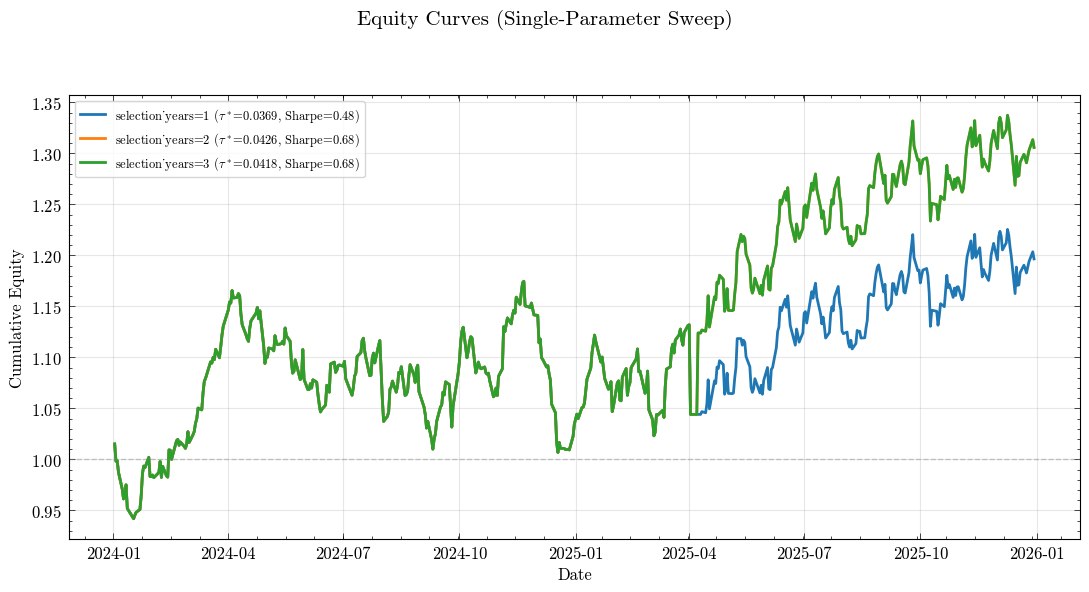

,selection_years,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
1,2,0.684846,0.689001,-9.165179,6.0,494,6
2,3,0.684846,0.689001,-9.165179,6.0,494,6
0,1,0.478198,0.482074,-2.436010,6.0,492,8


In [647]:
train_size = [1, 2, 3]


out_sweep = sweep_one_param_and_plot(
    values=train_size,
    param_name="selection_years",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['selection_years', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

cutoff times

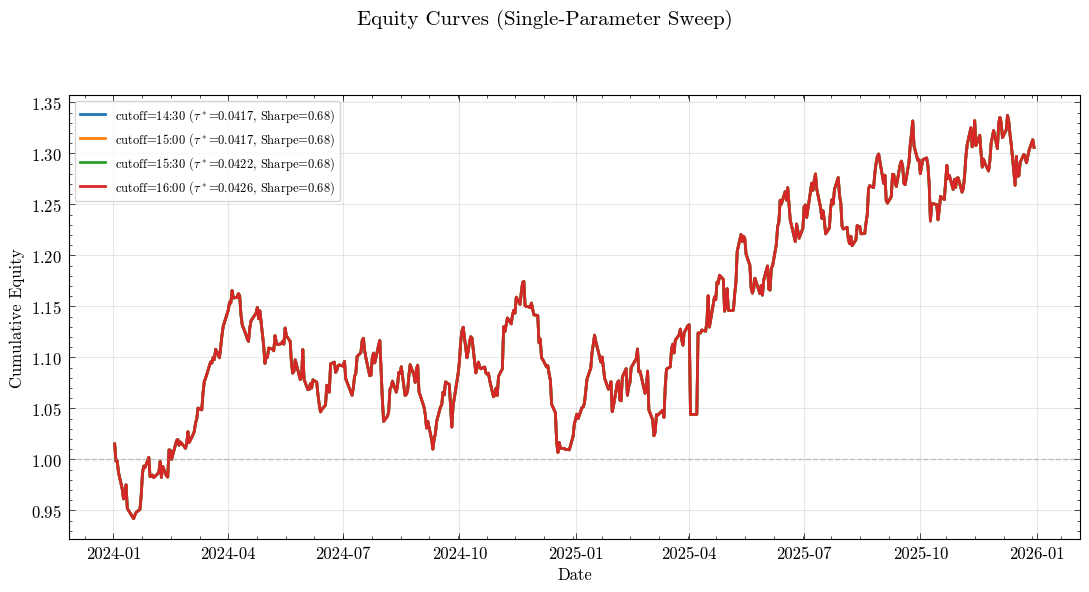

,cutoff,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
0,14:30,0.684846,0.689001,-9.165179,6.0,494,6
1,15:00,0.684846,0.689001,-9.165179,6.0,494,6
2,15:30,0.684846,0.689001,-9.165179,6.0,494,6
3,16:00,0.684846,0.689001,-9.165179,6.0,494,6


In [648]:
cutoffs = ["14:30","15:00", "15:30", "16:00"]


out_sweep = sweep_one_param_and_plot(
    values=cutoffs,
    param_name="cutoff",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['cutoff', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

grid size

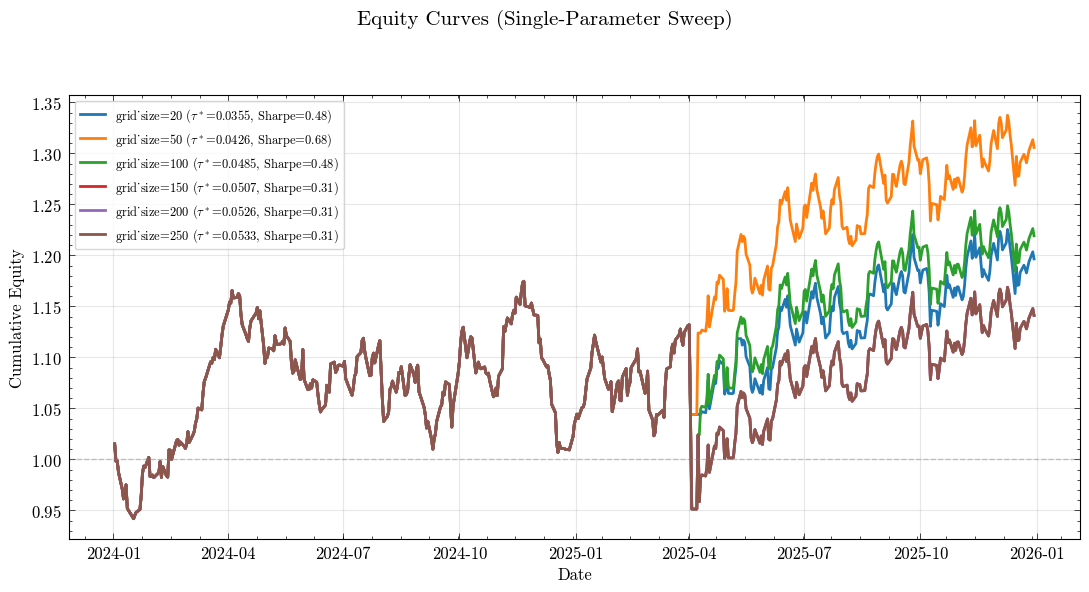

,grid_size,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
1,50,0.684846,0.689001,-9.165179,6.0,494,6
2,100,0.480372,0.482307,-10.219513,6.0,496,4
0,20,0.478198,0.482074,-2.436010,6.0,492,8
3,150,0.312083,0.313023,-3.969635,4.0,497,3
4,200,0.312083,0.313023,-3.969635,4.0,497,3
5,250,0.312083,0.313023,-3.969635,4.0,497,3


In [649]:
gridsize = [20, 50, 100,150, 200, 250]


out_sweep = sweep_one_param_and_plot(
    values=gridsize,
    param_name="grid_size",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['grid_size', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

q bounds

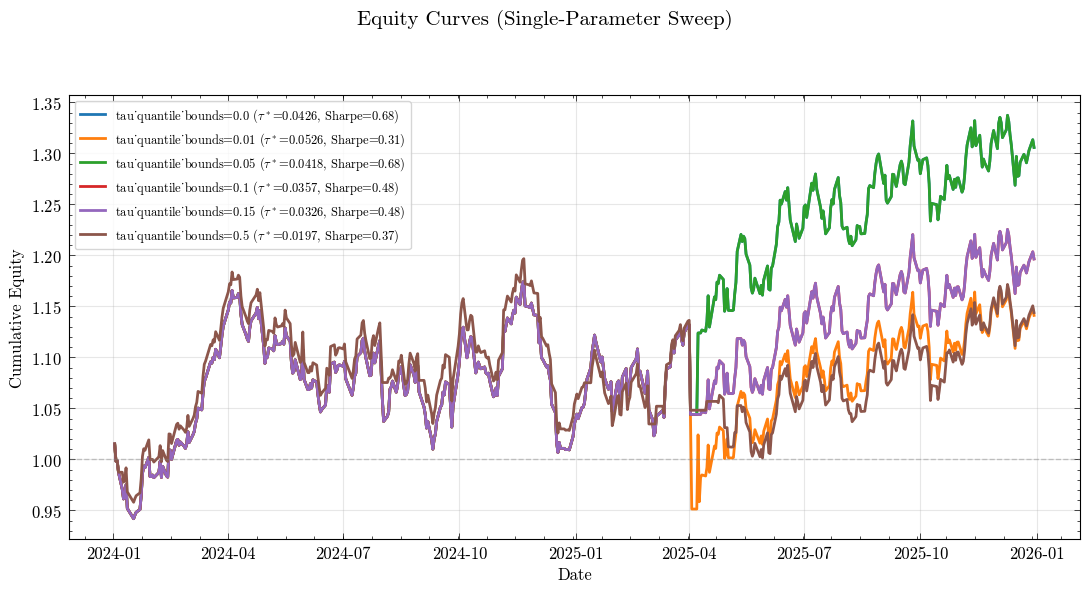

,tau_quantile_bounds,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
0,0.00,0.684846,0.689001,-9.165179,6.0,494,6
2,0.05,0.684846,0.689001,-9.165179,6.0,494,6
4,0.15,0.478198,0.482074,-2.436010,6.0,492,8
3,0.10,0.478198,0.482074,-2.436010,6.0,492,8
5,0.50,0.371812,0.386810,-0.261255,42.0,462,38
1,0.01,0.312083,0.313023,-3.969635,4.0,497,3


In [650]:
quantile_bounds = [0, .01, .05, .1, .15, .5]


out_sweep = sweep_one_param_and_plot(
    values=quantile_bounds,
    param_name="tau_quantile_bounds",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['tau_quantile_bounds', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

risk free rate

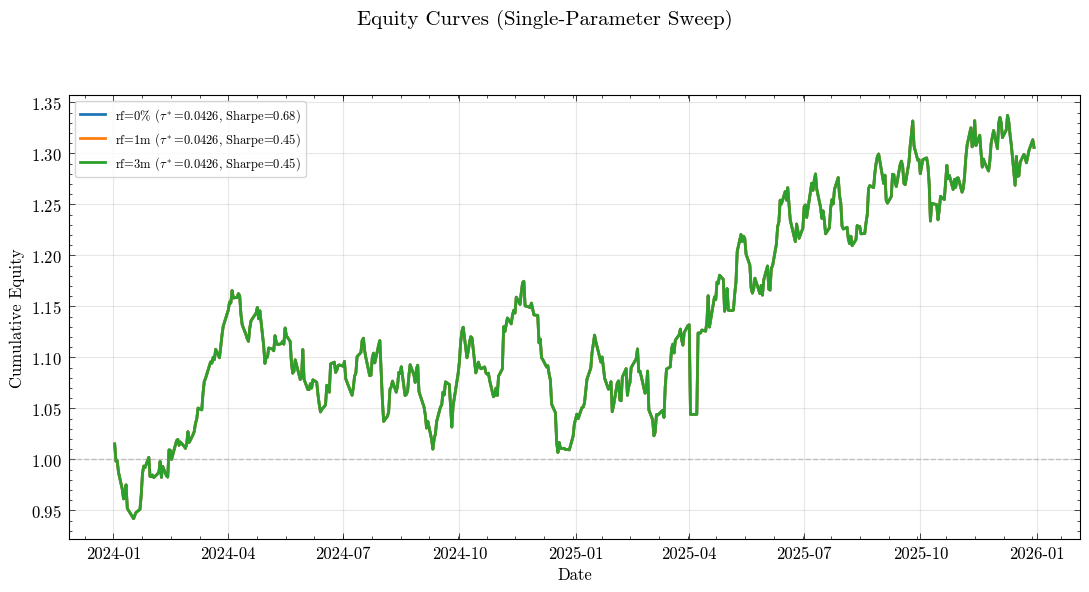

,rf,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
0,0%,0.684846,0.689001,-9.165179,6.0,494,6
2,3m,0.454852,0.460205,-9.227252,6.0,494,6
1,1m,0.451492,0.456841,-9.227548,6.0,494,6


In [651]:
rfs=["0%", "1m", "3m"]


out_sweep = sweep_one_param_and_plot(
    values=rfs,
    param_name="rf",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['rf', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

transaction cost

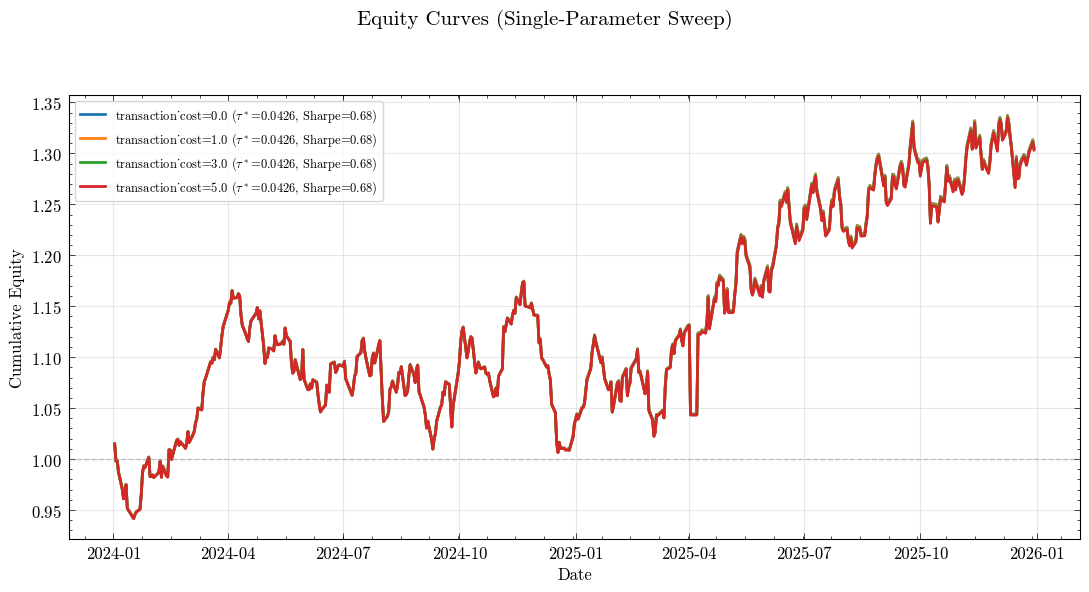

,transaction_cost,c2c_sharpe,c2c_sharpe_buy_regime,o2c_sharpe_no_buy_regime,c2c_turnover,c2c_num_buy_days,c2c_num_no_buy_days
0,0.0,0.684846,0.689001,-9.165179,6.0,494,6
1,1.0,0.683898,0.689001,-9.165179,6.0,494,6
2,3.0,0.682000,0.689001,-9.165179,6.0,494,6
3,5.0,0.680100,0.689001,-9.165179,6.0,494,6


In [652]:
transaction_costs = [.0, 1, 3, 5]


out_sweep = sweep_one_param_and_plot(
    values=transaction_costs,
    param_name="transaction_cost",
    base_kwargs=base_kwargs,
    plot_strategy="c2c",   # choose: "c2c" or "o2c"
)

summary_df = out_sweep["summary"]
equity_long = out_sweep["equity_long"]

display(summary_df[['transaction_cost', 'c2c_sharpe', 'c2c_sharpe_buy_regime', 'o2c_sharpe_no_buy_regime', 'c2c_turnover', 'c2c_num_buy_days', 'c2c_num_no_buy_days']].sort_values("c2c_sharpe", ascending=False))

## Parameter Grid

In [653]:
from itertools import product

def run_sweep(
    *,
    intraday_freqs: list[str],
    cutoffs: list[str],
    selection_years_list: list[int | float],
    grid_sizes: list[int],
    rfs: list[str],
    transaction_costs: list[int | float],
    tau_quantile_bounds_list: list[tuple[float, float]] = [(0.0, 1.0)],
) -> dict:
    summaries = []
    equities = []
    thresholds_all = []

    for intraday_freq, cutoff, selection_years, grid_size, rf, qbounds, transaction_bps in product(
        intraday_freqs, cutoffs, selection_years_list, grid_sizes, rfs, tau_quantile_bounds_list, transaction_costs
    ):
        out = run_one(
            intraday_freq=intraday_freq,
            cutoff=cutoff,
            selection_years=selection_years,
            grid_size=grid_size,
            rf=rf,
            tau_quantile_bounds=qbounds,
            transaction_cost=transaction_bps
        )

        summaries.append(out["summary"])
        equities.append(out["equity_long"])

        if out["thresholds"] is not None:
            thresholds_all.append(out["thresholds"])

    runs_summary = pd.DataFrame(summaries)
    equity_curves = pd.concat(equities, ignore_index=True)

    thresholds = pd.concat(thresholds_all, ignore_index=True) if thresholds_all else None

    return {
        "runs_summary": runs_summary,
        "equity_curves": equity_curves,
        "thresholds": thresholds,
    }


In [654]:
def save_dashboard_tables(
    out: dict,
    *,
    tag: str = "rv_sweep",
) -> dict:
    """
    Saves dashboard tables to: root/data/dashboard/<tag>/
    Assumes notebook is run from root/notebooks/
    """

    # notebook cwd = root/notebooks
    project_root = Path.cwd().parent   # go up to root/
    base = project_root / "results" / tag
    base.mkdir(parents=True, exist_ok=True)

    paths = {}



    runs_path = base / "runs_summary.parquet"
    out["runs_summary"].to_parquet(runs_path, index=False)
    paths["runs_summary"] = str(runs_path)

    eq_path = base / "equity_curves.parquet"
    # out["equity_curves"].to_parquet(eq_path, partition_cols=["run_id"], index=False)
    out["equity_curves"].to_parquet(eq_path, index=False)
    paths["equity_curves"] = str(eq_path)

    if out.get("thresholds") is not None:
        th_path = base / "thresholds.parquet"
        # out["thresholds"].to_parquet(th_path, partition_cols=["run_id"], index=False)
        out["thresholds"] .to_parquet(th_path, index=False)
        paths["thresholds"] = str(th_path)

    return paths

In [655]:
# sweep_out = run_sweep(
#     intraday_freqs=["5min" ,"10min", "15min"],
#     cutoffs=["15:00", "15:30", "16:00"],
#     selection_years_list=[1, 2, 3],
#     grid_sizes=[20, 50, 100],
#     rfs=["0%", "1m", "3m"],
#     tau_quantile_bounds_list=[0, .1, .15, .25],  # use interior quantiles
#     transaction_costs = [0, 3, 5]
# )


# paths = save_dashboard_tables(sweep_out, tag="xle_rv_sweep")
# print(paths)
